In [1]:
import numpy as np
import glob
import datetime as dt
import pandas as pd
import CESfunctionsJUNOx23 as cf
import matplotlib.pyplot as plt

In [18]:
## data from  (set 13+) , 2 reference

def Mfile_read3(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    col7 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        col7.append(float(ele[6]))
        

    return col1,col2,col3,col4,col5,col6,col7

In [8]:
####use the next two for sets 1 to 7
path = '.\\set7\\'
bfile = glob.glob(path + 'Ib*')
zfile = glob.glob(path + 'Iz*')
mfiles = glob.glob(path + 'Im*.txt')
Mfile = glob.glob(path + 'M*.txt')
savefile = path + 'Mtemp.txt'
dateM,ppbM,presM,temM = cf.Mfile_read(Mfile[0])
ppbs = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
for ii,ele in enumerate(mfiles):
    tstamp = dt.datetime.strptime(ele[-16:-4],'%y%m%d%H%M%S')
    
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    background=np.loadtxt(bfile[0])
    
    # Use the following zeroair for sets 4 to 7
    zeroair=np.loadtxt(zfile[0])
    
    #for sets 1 to 3 use the commented instead
    #z = zfile[1]
    #tstampz = dt.datetime.strptime(z[-14:-4],'%y%m%d%H%M%S')
    #if (tstampz-tstamp).total_seconds() > 0:
    #    zeroair=np.loadtxt(zfile[0])
    #else:
    #    zeroair=np.loadtxt(zfile[1])
    
    Im=np.loadtxt(ele)
    no2reference= np.load('NO2_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor

    counts = np.copy(Im[:,1]).reshape(len(Im[:,1]),1)
    minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

    bckg = np.copy(background[minwave:maxwave,:])
    zero = np.copy(zeroair[minwave:maxwave,:])
    no2ref = np.copy(no2reference[minwave:maxwave,:])
    I_s = np.copy(counts[minwave:maxwave,:])
    I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
    I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
    I_0 = np.subtract(I_not,I_b)
    I_sample = np.subtract(I_s,I_b)
    pres = float(presM[ii])
    tem = float(temM[ii])
    pPa = 6894.757293 * pres
    tK = 273.15 + tem

    alpha,fl,a,b,ndensity1 = cf.fit_alg_1A(I_sample, I_0, Reff, 44.17, 
            no2ref,pPa,tK,parameters=1)
    
   
    conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
    ppbs.append(conc)
    meastime.append(tstamp.strftime('%Y/%m/%d-%H:%M:%S'))
    mfca_ps.append(pres)
    mfca_ts.append(tem)
    flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,mfca_ps,mfca_ts,flag)),fmt='%s')

In [11]:
## for data from 22/06 midnight to 23/06 7am (set8)

def Mfile_read2(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        

    return col1,col2,col3,col4,col5,col6

path = '.\\set8\\'
ibzmfiles = glob.glob(path+'Ibzm*')
shotsb = 6
shotsz = 6
start_avg = 2
ppbs = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
savefile = path+'Mtemp.txt'


for ele in ibzmfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    #dateM,ppbM,presM,temM,truerefM,flagM = Mfile_read2(mfilename)
    full_mat = np.load(ele)
    background=np.copy(full_mat[:,:shotsb+1])
    zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
    Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    no2reference= np.load('NO2_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor
    
    for ii in range(len(ppbM)):
    

        counts = np.copy(Ims[:,ii+1]).reshape(len(Ims[:,ii+1]),1)
        minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

        bckg = np.copy(background[minwave:maxwave,:])
        zero = np.copy(zeroair[minwave:maxwave,:])
        no2ref = np.copy(no2reference[minwave:maxwave,:])
        I_s = np.copy(counts[minwave:maxwave,:])
        I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
        I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
        I_0 = np.subtract(I_not,I_b)
        I_sample = np.subtract(I_s,I_b)
        pres = float(presM[ii])
        tem = float(temM[ii])
        pPa = 6894.757293 * pres
        tK = 273.15 + tem
        alpha,fl,a,b,ndensity1 = cf.fit_alg_1A(I_sample, I_0, Reff, 44.17, 
            no2ref,pPa,tK,parameters=1)
    
        
        conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
        ppbs.append(conc)
        meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))
        mfca_ps.append(pres)
        mfca_ts.append(tem)
        flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,mfca_ps,mfca_ts,flag)),fmt='%s')



In [11]:
## data from 06/23 7.20 (set 9+)

def Mfile_read2(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        

    return col1,col2,col3,col4,col5,col6

path = '.\\set12\\'
ibzmfiles = glob.glob(path+'Ibzm*')
shotsb = 6
shotsz = 6
start_avg = 2
ppbs = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
savefile = path+'Mtemp.txt'


for ele in ibzmfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,presM,temM,truerefM,flagM = Mfile_read2(mfilename)
    full_mat = np.load(ele)
    background=np.copy(full_mat[:,:shotsb+1])
    zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
    Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    no2reference= np.load('NO2_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor
    
    for ii in range(len(ppbM)):
    

        counts = np.copy(Ims[:,ii+1]).reshape(len(Ims[:,ii+1]),1)
        minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

        bckg = np.copy(background[minwave:maxwave,:])
        zero = np.copy(zeroair[minwave:maxwave,:])
        no2ref = np.copy(no2reference[minwave:maxwave,:])
        I_s = np.copy(counts[minwave:maxwave,:])
        I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
        I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
        I_0 = np.subtract(I_not,I_b)
        I_sample = np.subtract(I_s,I_b)
        pres = float(presM[ii])
        tem = float(temM[ii])
        pPa = 6894.757293 * pres
        tK = 273.15 + tem
        
        alpha,fl,a,b,ndensity1 = cf.fit_alg_1A(I_sample, I_0, Reff, 44.17, 
            no2ref,pPa,tK,parameters=1)
    
        
        conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
        ppbs.append(conc)
        meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))
        mfca_ps.append(pres)
        mfca_ts.append(tem)
        flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,mfca_ps,mfca_ts,flag)),fmt='%s')



AttributeError: module 'CESfunctionsJUNOx23' has no attribute 'fit_alg_1B'

In [3]:
## data from 06/23 7.20 (set 9+) if you want two references

def Mfile_read2(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        

    return col1,col2,col3,col4,col5,col6

path = '.\\set12\\'
ibzmfiles = glob.glob(path+'Ibzm*')
shotsb = 6
shotsz = 6
start_avg = 2
ppbs = []
ppbs2 = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
savefile = path+'Mtemp2ref.txt'


for ele in ibzmfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,presM,temM,truerefM,flagM = Mfile_read2(mfilename)
    full_mat = np.load(ele)
    background=np.copy(full_mat[:,:shotsb+1])
    zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
    Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    no2reference= np.load('NO2_JUNOx23.npy')
    chochoreference = np.load('CHOCHO_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor
    
    for ii in range(len(ppbM)):
    
        if ii == 0:
            continue
            
        counts = np.copy(Ims[:,ii+1]).reshape(len(Ims[:,ii+1]),1)
        minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

        bckg = np.copy(background[minwave:maxwave,:])
        zero = np.copy(zeroair[minwave:maxwave,:])
        no2ref = np.copy(no2reference[minwave:maxwave,:])
        chochoref = np.copy(chochoreference[minwave:maxwave,:])
        I_s = np.copy(counts[minwave:maxwave,:])
        I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
        I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
        I_0 = np.subtract(I_not,I_b)
        I_sample = np.subtract(I_s,I_b)
        pres = float(presM[ii])
        tem = float(temM[ii])
        pPa = 6894.757293 * pres
        tK = 273.15 + tem
        
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
            no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1,itn=100)
        #print(ndensity1,ndensity2)
        #print('------------------------')
    
        
        conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
        conc2 = (ndensity2*1e15*1.380649e-23*tK/pPa)
        ppbs.append(conc)
        ppbs2.append(conc2)
        meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))
        mfca_ps.append(pres)
        mfca_ts.append(tem)
        flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,ppbs2,mfca_ps,mfca_ts,flag)),fmt='%s')



In [16]:
## data from 06/23 7.20 (set 9+) if you want two references

def Mfile_read2(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        

    return col1,col2,col3,col4,col5,col6

path = '.\\set12\\'
ibzmfiles = glob.glob(path+'Ibzm*')
shotsb = 6
shotsz = 6
start_avg = 2
ppbs = []
ppbs2 = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
trueref=[]
savefile = path+'Mtemp2ref.txt'


for ele in ibzmfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,presM,temM,truerefM,flagM = Mfile_read2(mfilename)
    full_mat = np.load(ele)
    background=np.copy(full_mat[:,:shotsb+1])
    zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
    Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    no2reference= np.load('NO2_JUNOx23.npy')
    chochoreference = np.load('CHOCHO_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor
    
    for ii in range(len(ppbM)):
    
        if ii == 0:
            continue
            
        counts = np.copy(Ims[:,ii+1]).reshape(len(Ims[:,ii+1]),1)
        minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

        bckg = np.copy(background[minwave:maxwave,:])
        zero = np.copy(zeroair[minwave:maxwave,:])
        no2ref = np.copy(no2reference[minwave:maxwave,:])
        chochoref = np.copy(chochoreference[minwave:maxwave,:])
        I_s = np.copy(counts[minwave:maxwave,:])
        I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
        I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
        I_0 = np.subtract(I_not,I_b)
        I_sample = np.subtract(I_s,I_b)
        pres = float(presM[ii])
        tem = float(temM[ii])
        pPa = 6894.757293 * pres
        tK = 273.15 + tem
        
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
            no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1,itn=100)
        #print(ndensity1,ndensity2)
        #print('------------------------')
    
        
        conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
        conc2 = (ndensity2*1e15*1.380649e-23*tK/pPa)
        ppbs.append(conc)
        ppbs2.append(conc2)
        meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))
        mfca_ps.append(pres)
        mfca_ts.append(tem)
        trueref.append(truerefM[ii])
        flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,ppbs2,mfca_ps,mfca_ts,trueref,flag)),fmt='%s')



In [14]:
## data from  (set 13+) , 2 reference

def Mfile_read3(mfilename):
    """This function reads a measurements text file (Mfile) and generates lists of the
    data. Mfile must be 2, 3 or 4 columns, we should not need more.
    Requires the filename.
    Returns 4 lists corresponding to 4 columns, excess columns are empty lists."""
    
    with open(mfilename) as f:
        lines = f.readlines()

    data = []

    for line in lines:
        a = line.strip('\n')
        data.append(a.split(' '))

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    col7 = []
    for ele in data:
        col1.append(dt.datetime.strptime(ele[0],'%Y/%m/%d-%H:%M:%S'))
        col2.append(float(ele[1]))
        
        col3.append(float(ele[2]))
        col4.append(float(ele[3]))
        col5.append(float(ele[4]))
        col6.append(float(ele[5]))
        col7.append(float(ele[6]))
        

    return col1,col2,col3,col4,col5,col6

path = '.\\set12\\'
ibzmfiles = glob.glob(path+'Ibzm*')
shotsb = 6
shotsz = 6
start_avg = 2
ppbs = []
ppbs2 = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
trueref = []
savefile = path+'Mtemp2ref.txt'


for ele in ibzmfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,ppbglyM,presM,temM,truerefM,flagM = Mfile_read2(mfilename)
    full_mat = np.load(ele)
    background=np.copy(full_mat[:,:shotsb+1])
    zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
    Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
    start_avg=2
    lower_wavelength = 395
    upper_wavelength = 420
    no2reference= np.load('NO2_JUNOx23.npy')
    chochoreference = np.load('CHOCHO_JUNOx23.npy')
    Refff = np.load('Reff.npy')
    #rfactor = .999912/Refff[58]
    rfactor =1
    Reff = Refff.reshape(len(Refff),1)*rfactor
    
    for ii in range(len(ppbM)):
    
        if ii == 0:
            continue
            
        counts = np.copy(Ims[:,ii+1]).reshape(len(Ims[:,ii+1]),1)
        minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

        bckg = np.copy(background[minwave:maxwave,:])
        zero = np.copy(zeroair[minwave:maxwave,:])
        no2ref = np.copy(no2reference[minwave:maxwave,:])
        chochoref = np.copy(chochoreference[minwave:maxwave,:])
        I_s = np.copy(counts[minwave:maxwave,:])
        I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
        I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
        I_0 = np.subtract(I_not,I_b)
        I_sample = np.subtract(I_s,I_b)
        pres = float(presM[ii])
        tem = float(temM[ii])
        pPa = 6894.757293 * pres
        tK = 273.15 + tem
        
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
            no2ref,chochoref,pPa,tK,parameters=1)
        #print(ndensity1,ndensity2)
        #alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, 44.17, 
        #    no2ref,chochoref,pPa,tK,parameters=1,itn=100)
        #print(ndensity1,ndensity2)
        #print('------------------------')
    
        
        conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
        conc2 = (ndensity2*1e15*1.380649e-23*tK/pPa)
        ppbs.append(conc)
        ppbs2.append(conc2)
        meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))
        mfca_ps.append(pres)
        mfca_ts.append(tem)
        treuref.append(truerefM[ii])
        flag.append(0)

np.savetxt(savefile,np.column_stack((meastime,ppbs,ppbs2,mfca_ps,mfca_ts,trueref,flag)),fmt='%s')



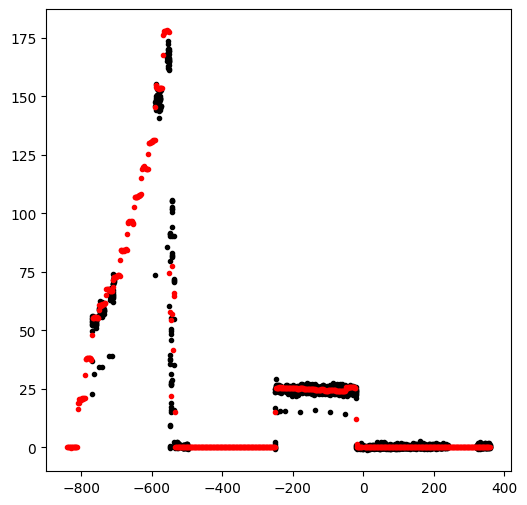

In [25]:
df1 = pd.read_csv('CEASam.dat')
df2 = pd.read_csv('FZJam.dat')
df2.columns = ['Time', 'NO', 'NO2', 'NOx','Flag']
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

ax1.plot(df1.Time,df1.NO2,'.k')
ax1.plot(df2.Time,df2.NO2,-r')

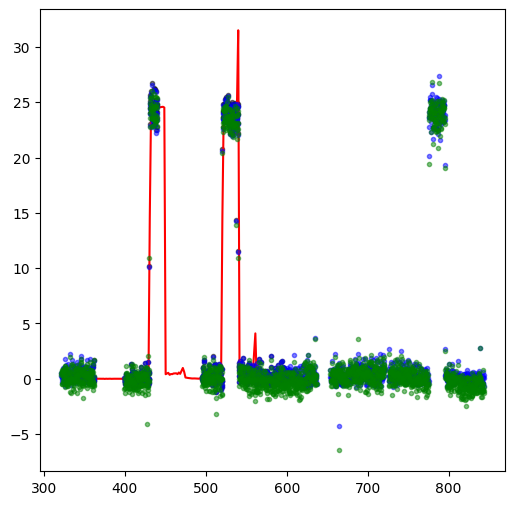

In [4]:
df1 = pd.read_csv('CEASpm.dat')
df2 = pd.read_csv('FZJpm.dat')
df3 = pd.read_csv('CEASpm2.dat')
df4 = pd.read_csv('CEASpm2ref.dat')
df2.columns = ['Time', 'NO', 'NO2', 'NOx','Flag']
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

ax1.plot(df1.Time,df1.NO2,'.k', alpha=0.5)
ax1.plot(df2.Time,df2.NO2,'-r')
ax1.plot(df3.Time,df3.NO2,'.b', alpha=0.5)
ax1.plot(df4.Time,df4.NO2,'.g', alpha=0.5)

(0.0, 50.0)

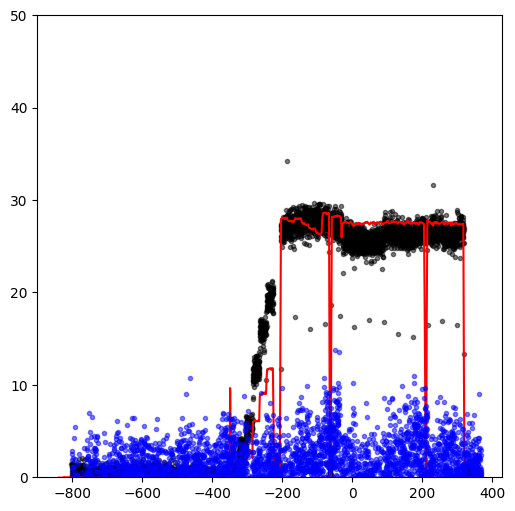

In [12]:
df1 = pd.read_csv('CEAS27am2ref.dat')
df2 = pd.read_csv('FZJ27am.dat')
df2.columns = ['Time', 'NO', 'NO2', 'NOx','Flag']
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

ax1.plot(df1.Time,df1.NO2,'.k', alpha=0.5)
ax1.plot(df2.Time,df2.NO2,'-r')
ax1.plot(df1.Time,df1.CHOCHO,'.b', alpha=0.5)
ax1.set_ylim(0,50)

In [10]:
df1.CHOCHO

0      -1.385283
1       2.869729
2      -1.059541
3      -1.490874
4      -0.490273
          ...   
5526   -4.877614
5527   -0.861418
5528   -0.024998
5529   -0.552494
5530   -0.442761
Name: CHOCHO, Length: 5531, dtype: float64

In [ ]:
#Mfile acumulator

In [10]:
path = '.\\set11\\'
mfiles = glob.glob(path+'M*')
ppbs = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
trueref = []
savefile = path+'Mtemp.txt'


for ele in mfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,presM,temM,truerefM,flagM = Mfile_read2(ele)
    
    for ii,ele2 in enumerate(dateM):
        if ii != 0:
            meastime.append(ele2.strftime('%Y/%m/%d-%H:%M:%S'))
            ppbs.append(ppbM[ii])
            mfca_ps.append(presM[ii])
            mfca_ts.append(temM[ii])
            trueref.append(truerefM[ii])
            flag.append(flagM[ii])
    #print(len(dateM),len(date),len(ppbM),len(presM),len(temM),len(truerefM),len(flagM))
    

print(len(meastime),len(ppbs),len(mfca_ps),len(mfca_ts),len(trueref),len(flag))
np.savetxt(savefile,np.column_stack((meastime,ppbs,mfca_ps,mfca_ts,trueref,flag)),fmt='%s')

1393 1393 1393 1393 1393 1393


In [25]:
# for two reference M files
path = '.\\set15\\'
mfiles = glob.glob(path+'M*')
ppbs = []
ppbsgly = []
flag = []
mfca_ps = []
mfca_ts = []
meastime=[]
trueref = []
savefile = path+'Mtemp.txt'


for ele in mfiles:
    mfilename = path+'M'+ele[-16:-4]+'.txt'
    #dateM,ppbM,presM,temM = cf.Mfile_read(mfilename)
    #when the new mfiles with trueref are on, use the following
    dateM,ppbM,ppbglyM,presM,temM,truerefM,flagM = Mfile_read3(ele)
    
    for ii,ele2 in enumerate(dateM):
        if ii != 0:
            meastime.append(ele2.strftime('%Y/%m/%d-%H:%M:%S'))
            ppbs.append(ppbM[ii])
            ppbsgly.append(ppbglyM[ii])
            mfca_ps.append(presM[ii])
            mfca_ts.append(temM[ii])
            trueref.append(truerefM[ii])
            flag.append(flagM[ii])
    #print(len(dateM),len(date),len(ppbM),len(presM),len(temM),len(truerefM),len(flagM))
    

print(len(meastime),len(ppbs),len(ppbsgly),len(mfca_ps),len(mfca_ts),len(trueref),len(flag))
np.savetxt(savefile,np.column_stack((meastime,ppbs,ppbsgly,mfca_ps,mfca_ts,trueref,flag)),fmt='%s')

5572 5572 5572 5572 5572 5572 5572


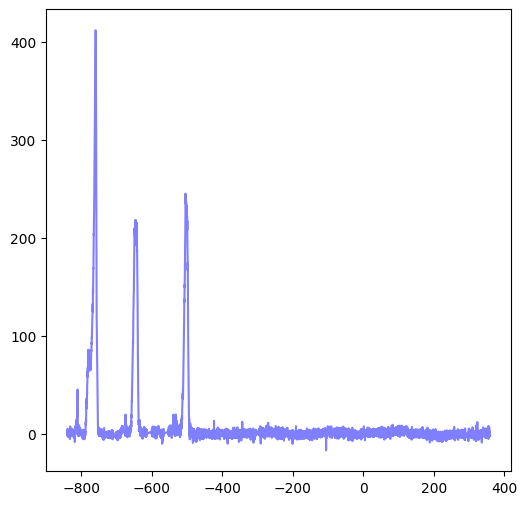

In [23]:
df1 = pd.read_csv('2023-06-28.COR_CEAS.am.dat')
#df2 = pd.read_csv('FZJ27am.dat')
#df2.columns = ['Time', 'NO', 'NO2', 'NOx','Flag']
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

#ax1.plot(df1.Time,df1.NO2,'.k', alpha=0.5)
#ax1.plot(df2.Time,df2.NO2,'-r')
ax1.plot(df1.Time,df1.CHOCHO,'-b', alpha=0.5)
#ax1.set_ylim(0,50)